# Remote Sensing - SpaceNet 6
Notebook Pyhton realizzato per il progetto del corso "Laboratorio di Intelligenza Artificiale" del prof. Ciarfuglia presso l'università La Sapienza.

In [14]:
import os
import torch
import dataset 
import utils
import model 

from torch.utils.data import DataLoader
from torchvision import transforms  
from sklearn.model_selection import train_test_split 
from torchsummary import summary


Verifico se la GPU è disponibile

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzo del dispositivo: {device}")

Utilizzo del dispositivo: cuda


Imposto il seed per migliorare la riproducibilità degli esperimenti.

In [16]:
RANDOM_SEED = 42
utils.set_seed(RANDOM_SEED)

Seed impostato su 42 per la riproducibilità.


## 1. Creazione della classe Dataset


Faccio un check se esiste effettivamente il percorso dati dove sto ricercando le immagini.

In [17]:
data_path = '../data/train/AOI_11_Rotterdam' 

if not os.path.isdir(data_path):
    print(f"ERRORE: La cartella dei dati non è stata trovata a '{data_path}'.")
else:
    print(f"Percorso dei dati configurato: {data_path}")


Percorso dei dati configurato: ../data/train/AOI_11_Rotterdam


Ricavo gli ID delle immagini, che mi serviranno della suddivisione dei vari set e che dovrò usare per tenere traccia di questa suddivsione.

In [18]:
sar_intensity_dir = os.path.join(data_path, 'SAR-Intensity')
all_image_ids = [
    os.path.splitext(f)[0] 
    for f in os.listdir(sar_intensity_dir) 
    if f.endswith('.tif') and os.path.isfile(os.path.join(sar_intensity_dir, f)) 
]

if not all_image_ids:
    raise RuntimeError(f"Nessun file .tif trovato in {sar_intensity_dir}. Impossibile procedere con la suddivisione.")

print(f"Trovati un totale di {len(all_image_ids)} immagini per la suddivisione.")


Trovati un totale di 3401 immagini per la suddivisione.


Imposto i valori percentuali per la suddivisione dei vari set ed attraverso la funzione di sci-kit learn effettuo la suddivisione tra train set e test set.

In [19]:
TEST_SIZE_RATIO = 0.10 
VALIDATION_SIZE_RATIO = 0.10 

train_val_ids, test_ids = train_test_split(
    all_image_ids, 
    test_size=TEST_SIZE_RATIO, 
    random_state=RANDOM_SEED,
    shuffle=True 
)

Eseguo come nella cella precedente, la suddivisione tra train set e validation set, utilizzando lo stesso metodo.

In [20]:
train_ids, val_ids = train_test_split(
    train_val_ids,
    test_size=VALIDATION_SIZE_RATIO, 
    random_state=RANDOM_SEED,
    shuffle=True 
)

print(f"\nSuddivisione del dataset:")
print(f"- Training set: {len(train_ids)} immagini")
print(f"- Validation set: {len(val_ids)} immagini")
print(f"- Test set: {len(test_ids)} immagini")
print(f"- Totale: {len(train_ids) + len(val_ids) + len(test_ids)} immagini")


Suddivisione del dataset:
- Training set: 2754 immagini
- Validation set: 306 immagini
- Test set: 341 immagini
- Totale: 3401 immagini


Come richiesto, vado a salvare gli ID delle immagini in 3 file 'train.txt', 'validation.txt' e 'test.txt' così da poter tenere traccia della suddivsione dei vari set e per fare più esperimenti sempre con la stessa suddivisione.

In [21]:
print("\nSalvataggio degli ID nei file .txt...")

utils.save_ids_to_file(train_ids, 'train.txt')
utils.save_ids_to_file(val_ids, 'validation.txt')
utils.save_ids_to_file(test_ids, 'test.txt')
print("Salvataggio completato.")



Salvataggio degli ID nei file .txt...
ID salvati in: ./train.txt
ID salvati in: ./validation.txt
ID salvati in: ./test.txt
Salvataggio completato.


Caricamento delle immagini nei vari set

In [22]:
custom_transforms = None 

train_dataset = dataset.SpaceNet6Dataset(base_data_path=data_path, image_ids_list=train_ids, transform=custom_transforms)
val_dataset = dataset.SpaceNet6Dataset(base_data_path=data_path, image_ids_list=val_ids, transform=custom_transforms)
test_dataset = dataset.SpaceNet6Dataset(base_data_path=data_path, image_ids_list=test_ids, transform=custom_transforms)

batch_size = 8 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()) 

print(f"\nSTATISTICHE DATA LOADERS:")
print(f" - Training DataLoader: {len(train_loader)} batch di {batch_size} immagini")
print(f" - Validation DataLoader: {len(val_loader)} batch di {batch_size} immagini")
print(f" - Test DataLoader: {len(test_loader)} batch di {batch_size} immagini")


Dataset inizializzato con 2754 coppie immagine-maschera.
Dataset inizializzato con 306 coppie immagine-maschera.
Dataset inizializzato con 341 coppie immagine-maschera.

STATISTICHE DATA LOADERS:
 - Training DataLoader: 345 batch di 8 immagini
 - Validation DataLoader: 39 batch di 8 immagini
 - Test DataLoader: 43 batch di 8 immagini


Per fare qualche controllo, vado a stampare qualche informazione su un elemento del batch del train_loader


Esempio di batch:
 - Dimensioni del batch di immagini (SAR): torch.Size([8, 4, 900, 900]) (Batch, Canali, Altezza, Larghezza)
 - Dimensioni del batch di maschere: torch.Size([8, 900, 900]) (Batch, Altezza, Larghezza)


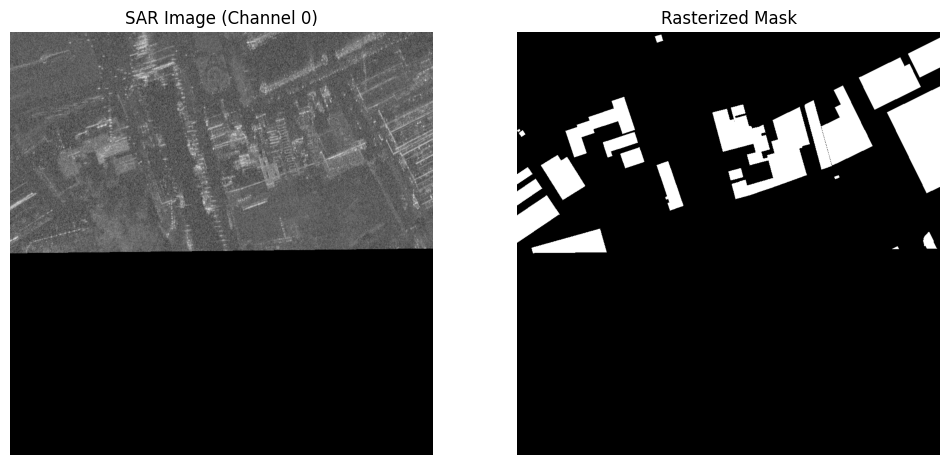

In [23]:
for images, masks in train_loader:
    print(f"\nEsempio di batch:")
    print(f" - Dimensioni del batch di immagini (SAR): {images.shape} (Batch, Canali, Altezza, Larghezza)") 
    print(f" - Dimensioni del batch di maschere: {masks.shape} (Batch, Altezza, Larghezza)")   
    break 

# Visualizzazione di un esempio
import matplotlib.pyplot as plt

sample_image = images[0] 
sample_mask = masks[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0].cpu().numpy(), cmap='gray') 
plt.title('SAR Image (Channel 0)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask.cpu().numpy(), cmap='gray')
plt.title('Rasterized Mask')
plt.axis('off')
plt.show()

## 2. Costruzione della U-NET

Procedo con l'inizializzazione del modello della U-Net definita nel file model.py.
Le immagini SAR in input hanno 4 canali, mentre le maschere di output per la segmentazione binaria hanno solamente 1 canale. Come features utilizzo questi valori che sono tutti multipli di 

In [24]:
INPUT_CHANNELS = 4 
OUTPUT_CHANNELS = 1 
SMALLER_FEATURES = [32, 64, 128, 256]
FEATURES = [64, 128, 256, 512] 
LARGER_FEATURES = [128, 256, 512, 1024]


Inizializzione del modello e stampa di un riepilogo delle informazioni riguardanti la struttura del modello. Infine vado a spostare il modello sulla GPU dove verranno eseguite le operazioni di training.

In [25]:
print(f"\nInizializzazione del modello U-Net...")
# Istanzia il modello U-Net
model_ = model.UNET(in_channels=INPUT_CHANNELS, out_channels=OUTPUT_CHANNELS, features=FEATURES)

# Sposta il modello sulla GPU
model_ = model_.to(device)

# Stampa un riepilogo del modello per verificarne la struttura (opzionale, ma utile)

print("Riepilogo del modello:")
# Passa un input di esempio con le dimensioni attese (canali, altezza, larghezza)
# Assumiamo che le tue immagini siano 4 canali, 161x161 pixel
summary(model_, input_size=(INPUT_CHANNELS, 161, 161), device=str(device))

print("Modello U-Net inizializzato e spostato sul dispositivo.")


Inizializzazione del modello U-Net...
Riepilogo del modello:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 161, 161]           2,304
       BatchNorm2d-2         [-1, 64, 161, 161]             128
              ReLU-3         [-1, 64, 161, 161]               0
            Conv2d-4         [-1, 64, 161, 161]          36,864
       BatchNorm2d-5         [-1, 64, 161, 161]             128
              ReLU-6         [-1, 64, 161, 161]               0
        DoubleConv-7         [-1, 64, 161, 161]               0
         MaxPool2d-8           [-1, 64, 80, 80]               0
            Conv2d-9          [-1, 128, 80, 80]          73,728
      BatchNorm2d-10          [-1, 128, 80, 80]             256
             ReLU-11          [-1, 128, 80, 80]               0
           Conv2d-12          [-1, 128, 80, 80]         147,456
      BatchNorm2d-13          [-1, 128, 8